In [1]:
# import libraries
import pandas as pd
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import seaborn as sns;
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.autograd import Function


In [2]:
# get the working directory
cwd = os.getcwd()

In [3]:
#load dataset
df = pd.read_csv(os.path.join(cwd, 'montrealbikes.csv'))

In [4]:
df.head()

,Date,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,33.0,49,21,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,30.0,113,27,9,...,NaN,109,177,32,13,NaN,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,30.0,107,36,12,...,NaN,71,131,33,5,NaN,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,10.0,35,29,1,...,NaN,6,11,6,1,NaN,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,27.0,90,21,1,...,NaN,0,5,49,20,NaN,0,41,56,10


In [5]:
df.fillna(0, inplace=True)

In [6]:
df['Unnamed: 1'].unique()

array(['00:00'], dtype=object)

In [7]:
# remove columns Unnamed: 1 since it doesn't have any valuable information
df.drop('Unnamed: 1', axis = 1, inplace = True)

In [8]:
cols_lanes = df.columns[1:]
print(cols_lanes)

Index(['Berri1', 'Boyer', 'Brébeuf', 'CSC (Côte Sainte-Catherine)',
       'Maisonneuve_1', 'Maisonneuve_2', 'Maisonneuve_3', 'Notre-Dame', 'Parc',
       'Parc U-Zelt Test', 'PierDup', 'Pont_Jacques_Cartier',
       'Rachel / Hôtel de Ville', 'Rachel / Papineau', 'René-Lévesque',
       'Saint-Antoine', 'Saint-Laurent U-Zelt Test', 'Saint-Urbain',
       'Totem_Laurier', 'University', 'Viger'],
      dtype='object')


These rows correspond to days of the year 2015 and the columns are the bike lanes in Montreal. The numbers in the cells are the number of bikes that used that lane.

### EDA

In [9]:
df.describe()

,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,Parc U-Zelt Test,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,...,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,2915.398119,2212.909091,2859.485893,1167.388715,17.479624,2208.031348,1011.175549,1137.316614,1754.257053,340.730408,...,1418.172414,2207.626959,2939.294671,1477.206897,207.476489,715.231975,1387.119122,1903.363636,2023.708464,295.347962
std,2276.281648,1832.808709,2337.531344,960.020397,42.272016,2452.475658,917.450049,991.065590,1415.004315,865.876458,...,1334.889423,1660.936427,2105.774880,1254.990855,231.009131,1785.863541,1070.781272,1376.375755,1632.368428,248.947624
min,10.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,20.000000,6.000000,0.000000
25%,387.500000,3.500000,33.000000,54.500000,0.000000,214.500000,119.000000,25.500000,61.000000,0.000000,...,0.000000,324.500000,513.000000,159.500000,15.500000,0.000000,244.500000,457.000000,352.500000,47.000000
50%,3044.000000,2180.000000,3011.000000,1162.000000,0.000000,689.000000,1049.000000,1067.000000,1787.000000,0.000000,...,1187.000000,2361.000000,3169.000000,1422.000000,107.000000,0.000000,1519.000000,1855.000000,1762.000000,267.000000
75%,4968.000000,3937.000000,5088.000000,1948.000000,0.000000,4114.500000,1675.000000,2094.500000,3025.500000,0.000000,...,2703.000000,3658.000000,4797.000000,2676.000000,337.000000,0.000000,2237.000000,3111.000000,3539.000000,526.000000
max,7387.000000,6153.000000,7322.000000,3334.000000,207.000000,7905.000000,9999.000000,3035.000000,4867.000000,3997.000000,...,6014.000000,7921.000000,7695.000000,4118.000000,781.000000,7388.000000,4342.000000,5166.000000,5596.000000,820.000000


In [10]:
print(len(df.columns))

22


There is 1 column with Date and 21 columns where each column corresponds to a bike lane in Montreal

In [11]:
# change format to datetime
df['Date_dt'] = pd.to_datetime(df.Date, format='%d/%m/%Y')

In [12]:
# sort df in ascending order
df = df.sort_values(by = 'Date_dt')

In [13]:
# Extract month, day, day of the week from Date
df['day'] = df.Date_dt.dt.day
df['month'] = df.Date_dt.dt.month
df['dow'] = df.Date_dt.dt.day_of_week

In [14]:
# get total number of bikes per day and add to df
val=[]
for i in range(len(df)):
    val.append(df[cols_lanes].iloc[i,:].values.sum())
    
df['total_bikes'] = val

In [15]:
df[cols_lanes]

,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,Parc U-Zelt Test,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,58,12,4,17,33.0,49,21,16,16,0.0,...,0.0,58,91,24,3,0.0,17,78,21,6
1,75,7,5,15,30.0,113,27,9,32,0.0,...,0.0,109,177,32,13,0.0,11,57,77,4
2,79,7,3,7,30.0,107,36,12,18,0.0,...,0.0,71,131,33,5,0.0,14,174,40,5
3,10,1,21,0,10.0,35,29,1,0,0.0,...,0.0,6,11,6,1,0.0,1,20,6,0
4,42,0,2,0,27.0,90,21,1,1,0.0,...,0.0,0,5,49,20,0.0,0,41,56,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,3044,1931,2828,1393,0.0,3603,1754,1142,2342,3997.0,...,950.0,2328,3280,1210,338,4065.0,1534,1527,2860,356
315,1751,930,1670,888,0.0,2048,700,675,1566,2945.0,...,467.0,1345,1877,755,180,2336.0,960,955,1777,198
316,1818,906,1711,873,0.0,2115,634,477,1522,1693.0,...,482.0,1416,1980,719,204,2628.0,978,1040,1727,258
317,979,759,978,322,0.0,1112,290,310,601,604.0,...,266.0,1061,1448,269,70,1876.0,640,805,737,73


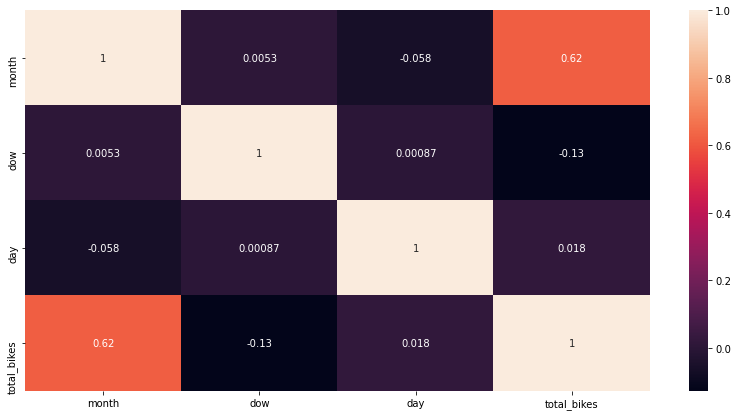

In [16]:
# correlation between month, day of week and the number of bokes
data_corr=df[["month","dow","day","total_bikes"]]
plt.figure(figsize=(14,7))
sns.heatmap(data_corr.corr(),annot=True)
plt.show()

Month and total bikes has only strong positive correlation. Day of the week and day have weak positive and negative correlations

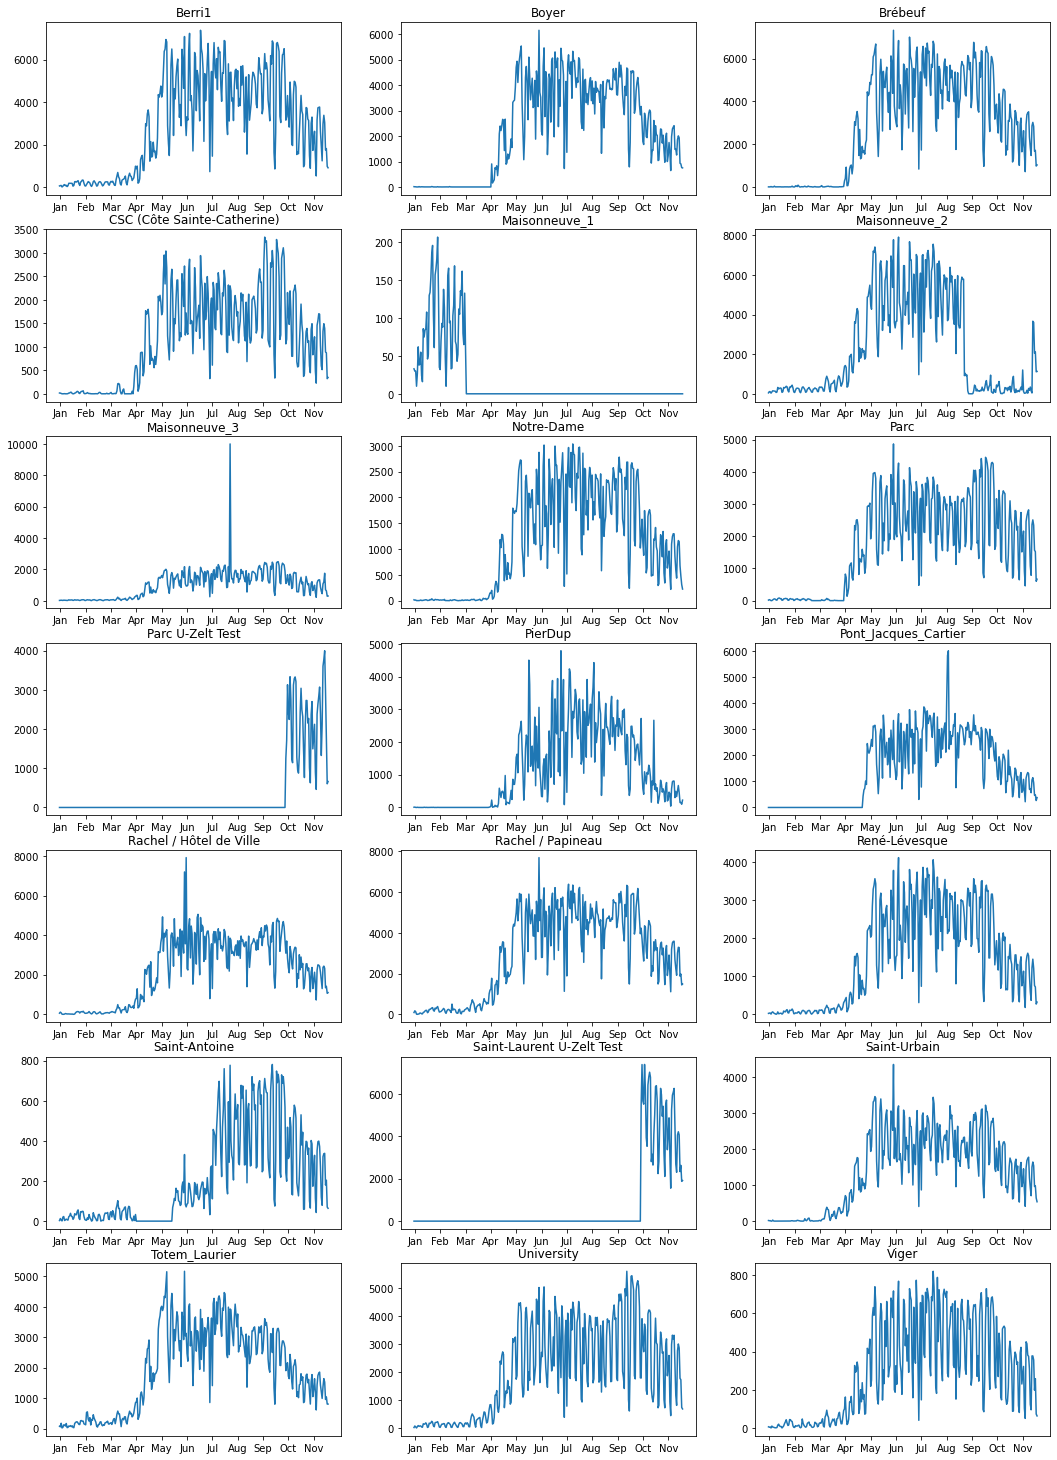

In [17]:
# Plot each lane by month
fig = plt.figure(figsize = (18, 26))

columns = 3
rows = 7

ax = []
#extract month names
months = list(df.Date_dt.dt.month_name().unique())
#shorten month names
mon = [mon[:3] for mon in months]

for i in range(columns * rows):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[i].set_title(cols_lanes[i])
    plt.setp(ax,xticks=np.arange(1,319,30), xticklabels=mon)
for i in range(len(cols_lanes)):
    ax[i].plot(df['Date'], df[cols_lanes[i]])

Some lanes are not operating during the whole year. But for all of the the winter months are the months with fewer bikers.

We can also see a box plot to get a better idea of a number of bikers.

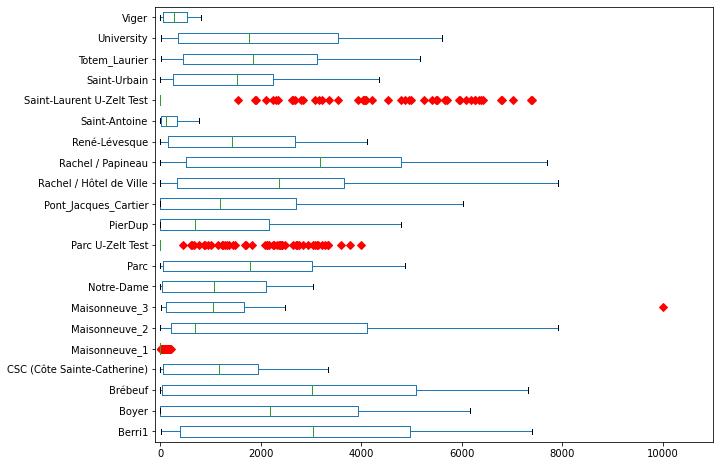

In [18]:
fig, ax = plt.subplots(figsize = (10, 8))
df[cols_lanes].plot(kind='box', sym='rD', vert=False, xlim=(-100,11000), ax = ax)
plt.show()

### PyTorch regression model

In [19]:
# Hyperparameters
batch_size= 150
learning_rate=1e-10


# Other constants
DATA_FILENAME = os.path.join(cwd, 'montrealbikes.csv')
TARGET_COLUMN = 'Viger' # We chose one bike lane as our dependent variable
input_size=16
output_size=1

In [20]:
# Download the data
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,Date,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,33.0,49,21,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,30.0,113,27,9,...,NaN,109,177,32,13,NaN,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,30.0,107,36,12,...,NaN,71,131,33,5,NaN,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,10.0,35,29,1,...,NaN,6,11,6,1,NaN,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,27.0,90,21,1,...,NaN,0,5,49,20,NaN,0,41,56,10


In [21]:
dataframe = dataframe.drop(columns=['Maisonneuve_1', 'Parc U-Zelt Test', 'Pont_Jacques_Cartier', 'Saint-Laurent U-Zelt Test'])
dataframe.head()

,Date,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,PierDup,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,49,21,16,16,7,58,91,24,3,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,113,27,9,32,11,109,177,32,13,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,107,36,12,18,2,71,131,33,5,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,35,29,1,0,0,6,11,6,1,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,90,21,1,1,6,0,5,49,20,0,41,56,10


In [22]:
# check which columns are missing values
df.isnull().sum(axis = 0)

Date                           0
Berri1                         0
Boyer                          0
Brébeuf                        0
CSC (Côte Sainte-Catherine)    0
Maisonneuve_1                  0
Maisonneuve_2                  0
Maisonneuve_3                  0
Notre-Dame                     0
Parc                           0
Parc U-Zelt Test               0
PierDup                        0
Pont_Jacques_Cartier           0
Rachel / Hôtel de Ville        0
Rachel / Papineau              0
René-Lévesque                  0
Saint-Antoine                  0
Saint-Laurent U-Zelt Test      0
Saint-Urbain                   0
Totem_Laurier                  0
University                     0
Viger                          0
Date_dt                        0
day                            0
month                          0
dow                            0
total_bikes                    0
dtype: int64

In [23]:
dataframe = dataframe.drop(columns=['Unnamed: 1', 'Date'])
dataframe.head()

,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,PierDup,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Urbain,Totem_Laurier,University,Viger
0,58,12,4,17,49,21,16,16,7,58,91,24,3,17,78,21,6
1,75,7,5,15,113,27,9,32,11,109,177,32,13,11,57,77,4
2,79,7,3,7,107,36,12,18,2,71,131,33,5,14,174,40,5
3,10,1,21,0,35,29,1,0,0,6,11,6,1,1,20,6,0
4,42,0,2,0,90,21,1,1,6,0,5,49,20,0,41,56,10


In [24]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop(TARGET_COLUMN, axis=1).values
targets = dataframe[[TARGET_COLUMN]].values
inputs.shape, targets.shape

((319, 16), (319, 1))

In [25]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [255, 64])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

In [26]:
# create a custom loss MSE
def mse_custom(output, target):
    loss = torch.mean((output - target)** 2)
    return loss

In [27]:
# create a custom loss MAE
def mae_custom(output, target):
    loss =torch.mean(torch.abs(output - target))
    return loss

In [28]:
class BikeLaneModel(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.loss_func = loss_func
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
        
    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                   # Generate predictions
#         loss = F.mse_loss(out, targets)      # Calculate loss
        loss = self.loss_func(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                   # Generate predictions      
#         loss = F.mse_loss(out, targets)      # Calculate loss
        loss = self.loss_func(out, targets)
        
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        if epoch % 20 == 0:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [29]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
mae_loss = torch.nn.L1Loss()

In [31]:
model = BikeLaneModel(mae_custom)
result = evaluate(model, val_loader)
result

{'val_loss': 715.747314453125}

In [32]:
history = fit(2000, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 715.7350
Epoch [20], val_loss: 715.4895
Epoch [40], val_loss: 715.2443
Epoch [60], val_loss: 714.9988
Epoch [80], val_loss: 714.7532
Epoch [100], val_loss: 714.5076
Epoch [120], val_loss: 714.2628
Epoch [140], val_loss: 714.0175
Epoch [160], val_loss: 713.7727
Epoch [180], val_loss: 713.5280
Epoch [200], val_loss: 713.2818
Epoch [220], val_loss: 713.0369
Epoch [240], val_loss: 712.7912
Epoch [260], val_loss: 712.5446
Epoch [280], val_loss: 712.2987
Epoch [300], val_loss: 712.0534
Epoch [320], val_loss: 711.8073
Epoch [340], val_loss: 711.5621
Epoch [360], val_loss: 711.3156
Epoch [380], val_loss: 711.0697
Epoch [400], val_loss: 710.8246
Epoch [420], val_loss: 710.5788
Epoch [440], val_loss: 710.3331
Epoch [460], val_loss: 710.0877
Epoch [480], val_loss: 709.8419
Epoch [500], val_loss: 709.5961
Epoch [520], val_loss: 709.3504
Epoch [540], val_loss: 709.1047
Epoch [560], val_loss: 708.8595
Epoch [580], val_loss: 708.6138
Epoch [600], val_loss: 708.3683
Epoch [620], v

691.1914672851562

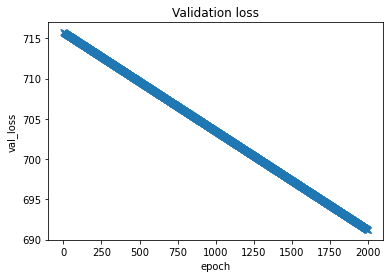

In [33]:

losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('Validation loss')
losses[-1]

### Custom losses and Forward/Backward functions

In [34]:
# we have to define forward and backward functions 
class LinearFunction(Function):
    
    @staticmethod
    def forward(ctx, input, weight): 
        ctx.save_for_backward(input, weight)
        
        output = input.mm(weight.t()) #mm - multpl, t - transpose
        return output
    
    
    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        grad_input = grad_weight = None
        
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(input)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.mm(weight)
    
        return grad_input, grad_weight

In [35]:
class Linear(nn.Module):
    def __init__(self, input_size, output_size):
        super(Linear, self).__init__()
        self.input_features = input_size
        self.output_features = input_size
        self.weight = nn.Parameter(torch.empty(output_size, input_size))
        
        # Initialize weights
        nn.init.uniform_(self.weight, -1, 1)
   
    def forward(self, input):
        return LinearFunction.apply(input, self.weight)
    

In [36]:
# define a variety of custom loss functions

In [37]:
# create a custom loss MAE
def mae_custom(output, target):
    loss =torch.mean(torch.abs(output - target))
    return loss

In [38]:
# create a custom loss MSE
def mse_custom(output, target):
    loss = torch.mean((output - target)** 2)
    return loss

In [39]:
def numpy_spearman(target, pred):
    pred = pd.Series(pred.detach().numpy().squeeze())
    target = pd.Series(target.detach().numpy().squeeze())
    
    corr = np.corrcoef(target, pred.rank(pct=True, method="first"))[0, 1]
    corr = torch.tensor(corr, requires_grad=True)
    return corr

In [40]:
def custom_spearman(output, target):
    vx = output - torch.mean(output)
    vy = target - torch.mean(target)

    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    return cost

In [41]:

model = Linear(input_size, output_size)
train_losses = []
val_losses = []

optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)
for epoch in range(20):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        
        #predictions
        out = model(inputs)                   # Generate predictions
        
#         loss = custom_spearman(out, targets)  
        
        loss = mae_custom(out, targets)  
#         loss = numpy_spearman(out, targets)  
#         loss = mse_custom(out, targets)    
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                #predictions
                val_out = model(val_inputs)                   # Generate predictions
                val_loss = mae_custom(val_out, val_targets)  
                val_losses.append(val_loss)

    print(f'epoch {epoch}, loss {loss}')    


epoch 0, loss 7301.9140625
epoch 1, loss 8124.18115234375
epoch 2, loss 7214.6865234375
epoch 3, loss 8649.380859375
epoch 4, loss 8588.2294921875
epoch 5, loss 8993.5
epoch 6, loss 9003.859375
epoch 7, loss 8792.828125
epoch 8, loss 9613.4697265625
epoch 9, loss 10026.6884765625
epoch 10, loss 9549.123046875
epoch 11, loss 10496.06640625
epoch 12, loss 10545.9716796875
epoch 13, loss 11043.2880859375
epoch 14, loss 10973.2939453125
epoch 15, loss 11010.8916015625
epoch 16, loss 11439.7763671875
epoch 17, loss 11940.3896484375
epoch 18, loss 11080.26171875
epoch 19, loss 11791.4384765625


In [42]:
input_size = 16 #because we have 16 variables
output_size = 1


model = Linear(input_size, output_size)
train_losses = []
val_losses = []

optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)
for epoch in range(50):
    for inputs, targets in train_loader:
        losses = 0
        optimizer.zero_grad()
        
        #predictions
        out = model(inputs)                   # Generate predictions
        
        loss = mae_custom(out, targets)  
#         loss = mse_custom(out, targets)  
#         loss = numpy_spearman(out, targets)  
#         loss = custom_spearman(out, targets)  
        losses += loss
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                losses_v = 0
                #predictions
                val_out = model(val_inputs)                   # Generate predictions
                val_loss = mae_custom(val_out, val_targets)  
#                 val_loss = mse_custom(val_out, val_targets)  
#                 val_loss = numpy_spearman(val_out, val_targets)  
#                 val_loss = custom_spearman(val_out, val_targets)    
                losses_v += val_loss
            
    train_losses.append(losses/ len(train_loader))
    val_losses.append(losses_v/ len(val_loader))
    
    print(f'epoch {epoch}, loss {loss}')    


epoch 0, loss 1090.55419921875
epoch 1, loss 1108.7440185546875
epoch 2, loss 1108.375
epoch 3, loss 983.0634765625
epoch 4, loss 1122.379150390625
epoch 5, loss 1002.0515747070312
epoch 6, loss 905.123046875
epoch 7, loss 1009.0260620117188
epoch 8, loss 970.88134765625
epoch 9, loss 888.3010864257812
epoch 10, loss 809.8737182617188
epoch 11, loss 904.923095703125
epoch 12, loss 792.441650390625
epoch 13, loss 908.0218505859375
epoch 14, loss 891.934814453125
epoch 15, loss 767.4279174804688
epoch 16, loss 706.9327392578125
epoch 17, loss 792.59033203125
epoch 18, loss 711.82177734375
epoch 19, loss 732.1076049804688
epoch 20, loss 734.752685546875
epoch 21, loss 622.2503051757812
epoch 22, loss 689.18896484375
epoch 23, loss 629.7254638671875
epoch 24, loss 581.4505004882812
epoch 25, loss 637.3876342773438
epoch 26, loss 603.9327392578125
epoch 27, loss 611.8987426757812
epoch 28, loss 598.6445922851562
epoch 29, loss 591.94482421875
epoch 30, loss 559.8336791992188
epoch 31, loss 

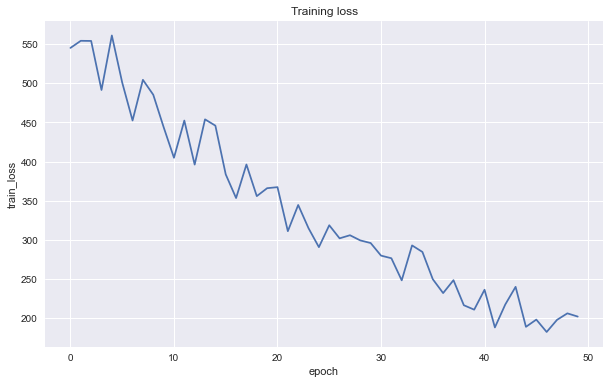

In [43]:
plt.style.use('seaborn')
fig, axes = plt.subplots(figsize = (10, 6))
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.title('Training loss')
plt.show()

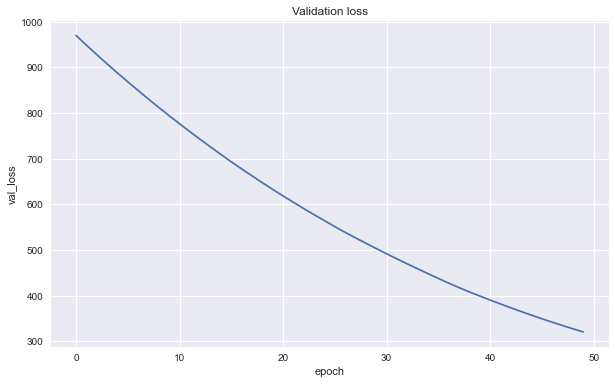

In [44]:
fig, axes = plt.subplots(figsize = (10, 6))
plt.plot(val_losses, '-x')

plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('Validation loss')
plt.show()

## Results:

1. mae_custom seems to work, but it is not stable: sometimes the loss goes up, and other time decreases.
2. mse_custom works with very little learning_rate: should be around 0.0001. In other cases the loss converts to inf.
3. numpy_spearman and custom_spearman don't converge; the training loss is about the same all the time and the eval loss is a constant.